In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from splinedist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from splinedist.matching import matching, matching_dataset
from splinedist.models import Config2D, SplineDist2D, SplineDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

import splinegenerator as sg
import os
os.environ['CUDA_VISIBLE_DEVICES']='3'

# Data

We assume that data has already been downloaded via notebook [1_data.ipynb](1_data.ipynb).  

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size. Label images need to be integer-valued.
</div>

In [2]:
X = sorted(glob('data/dsb2018/train/images/*.tif'))
Y = sorted(glob('data/dsb2018/train/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [3]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

Normalize images and fill small label holes.

In [4]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 447/447 [00:01<00:00, 306.71it/s]


Split into train and validation datasets.

In [5]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 447
- training:       380
- validation:      67


Training data consists of pairs of input image and label instances.

In [6]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

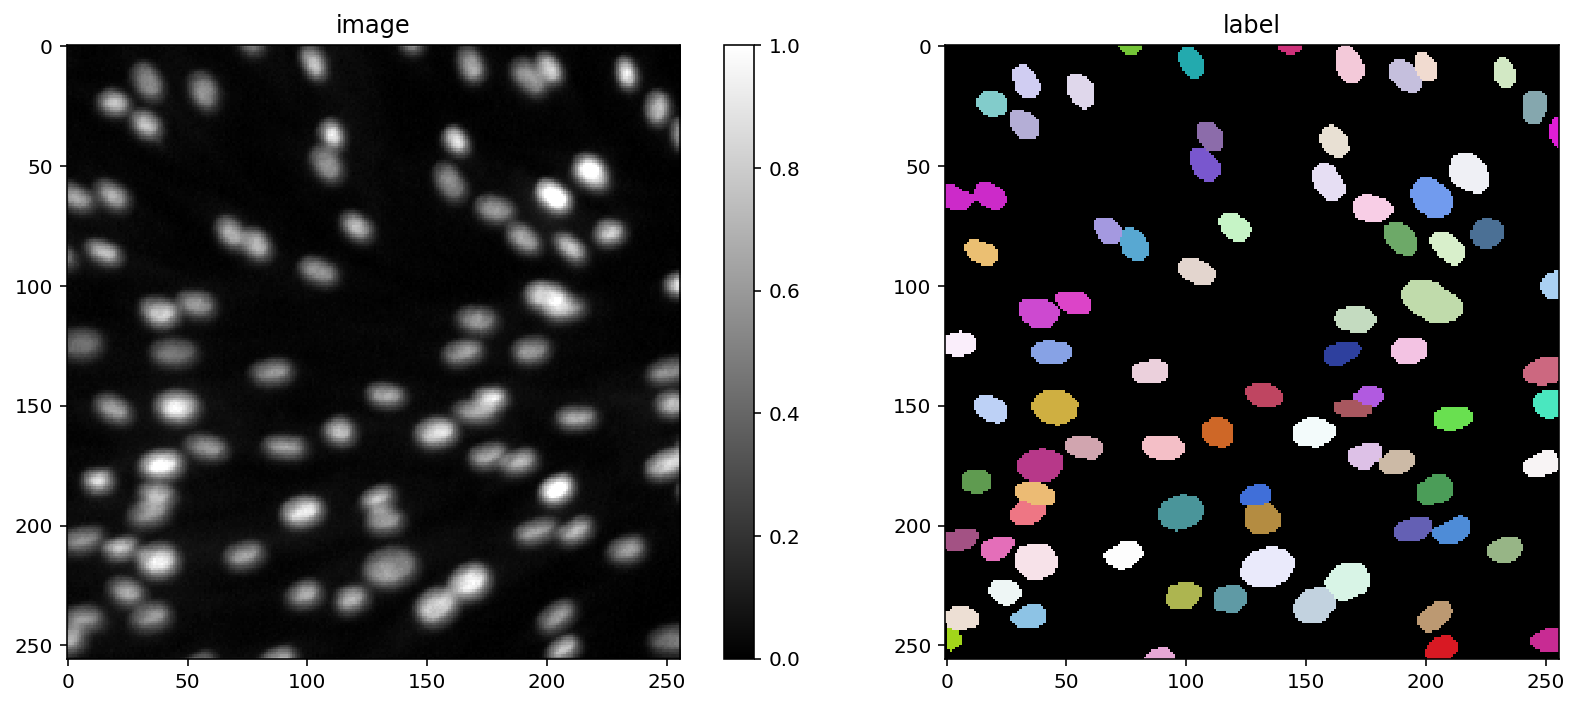

In [7]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
None;

# Configuration

A `SplineDist2D` model is specified via a `Config2D` object.

In [8]:
print(Config2D.__doc__)

Configuration for a :class:`SplineDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_params : int
        2 * number of control points
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
        Convolution kernel size for all (U-Net) convolution layers.
    unet_n_filter_base : int
        Number of convolution kernels (feature channels) for first U-Net layer.
        Doubled after 

In [9]:
# 32 is a good default choice (see 1_data.ipynb)
M = 6

n_params = 2 * M

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_params       = n_params,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=13, n_dim=2, n_params=12, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=False)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 13,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_params': 12,
 'grid': (2, 2),
 'backbone': 'unet',
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,
 'train_batch_size': 4,
 'train_n_val_patches': None,
 'train_tensorboard': Tru

In [10]:
def wrapIndex(t, k, M, half_support):
    wrappedT = t - k
    t_left = t - half_support
    t_right = t + half_support
    if k < t_left:
        if t_left <= k + M <= t_right:
            wrappedT = t - (k + M)
    elif k > t + half_support:
        if t_left <= k - M <= t_right:
            wrappedT = t - (k - M)
    return wrappedT

contour_size = 400

ts = np.linspace(0, float(M), num=contour_size, endpoint=False)
wrapped_indices = np.array([[wrapIndex(t, k, M, 2)
                             for k in range(M)] for t in ts])
vfunc = np.vectorize(sg.B3().value)
phi = vfunc(wrapped_indices)     
phi = phi.astype(np.float32)
np.save('phi_' + str(M) + '.npy',phi)

coord = np.ones((256,256,M, 2))

xgrid_points = np.linspace(0,coord.shape[0]-1,coord.shape[0])
ygrid_points = np.linspace(0,coord.shape[1]-1,coord.shape[1])
xgrid, ygrid = np.meshgrid(xgrid_points,ygrid_points)
xgrid, ygrid = np.transpose(xgrid), np.transpose(ygrid)
grid = np.stack((xgrid,ygrid),axis = 2)
grid = np.expand_dims(grid, axis = 2)
grid = np.repeat(grid, coord.shape[2], axis = 2)
grid = np.expand_dims(grid, axis = 0)

grid = grid[:,0::2,0::2]
grid = grid.astype(np.float32)

np.save('grid_' + str(M) + '.npy', grid)

In [11]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)

In [12]:
model = SplineDist2D(conf, name='splinedist', basedir='models')

/home/smandal/anaconda3/envs/splinedist_contour/lib/python3.8/site-packages/csbdeep/models/base_model.py:148: UserWarning: output path for model already exists, files may be overwritten: /home/smandal/work/splinedist/models/splinedist
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


Using default values: prob_thresh=0.5, nms_thresh=0.4.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [13]:
# median_size = calculate_extents(list(Y), np.median)
# fov = np.array(model._axes_tile_overlap('YX'))
# print(f"median object size:      {median_size}")
# print(f"network field of view :  {fov}")
# if any(median_size > fov):
#     print("WARNING: median object size larger than field of view of the neural network.")

# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [14]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

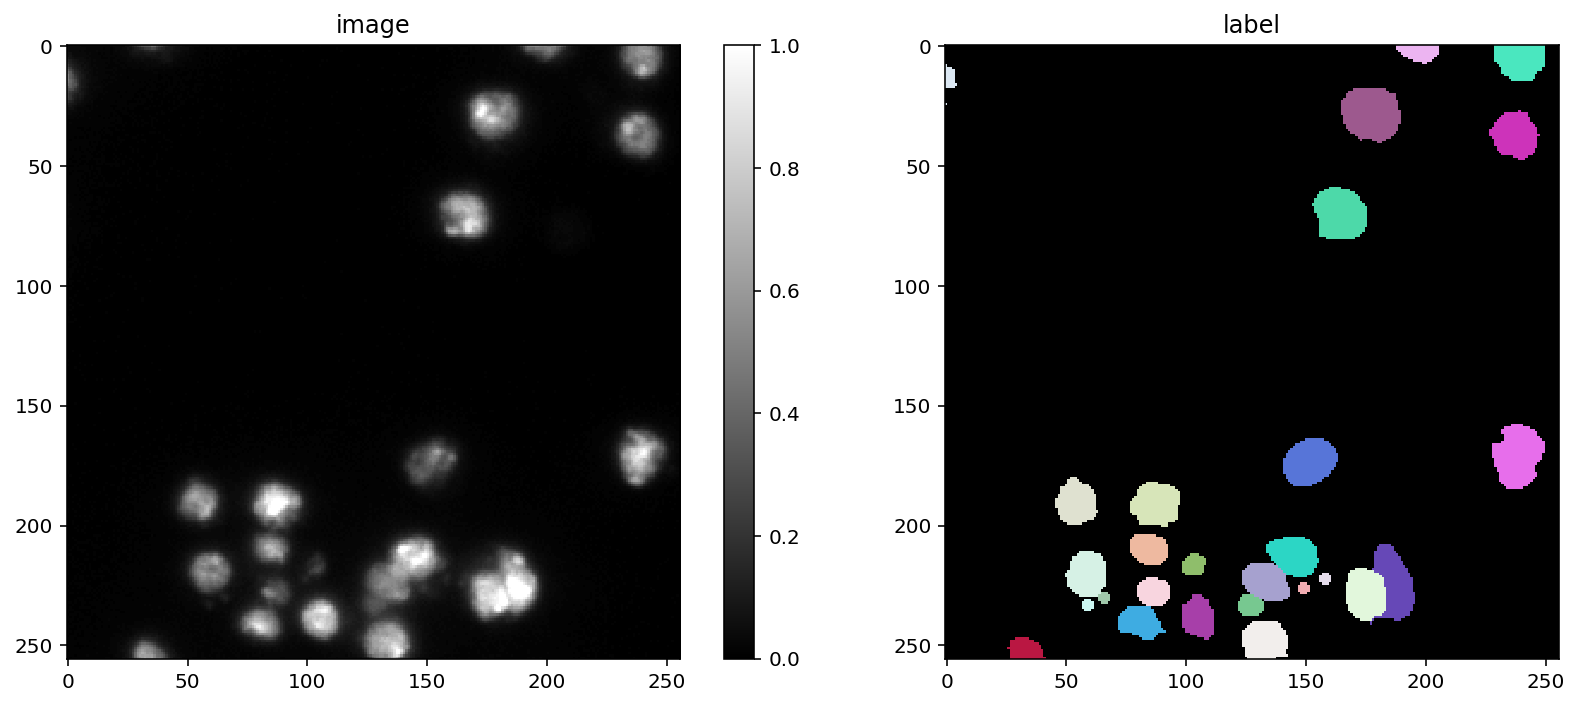

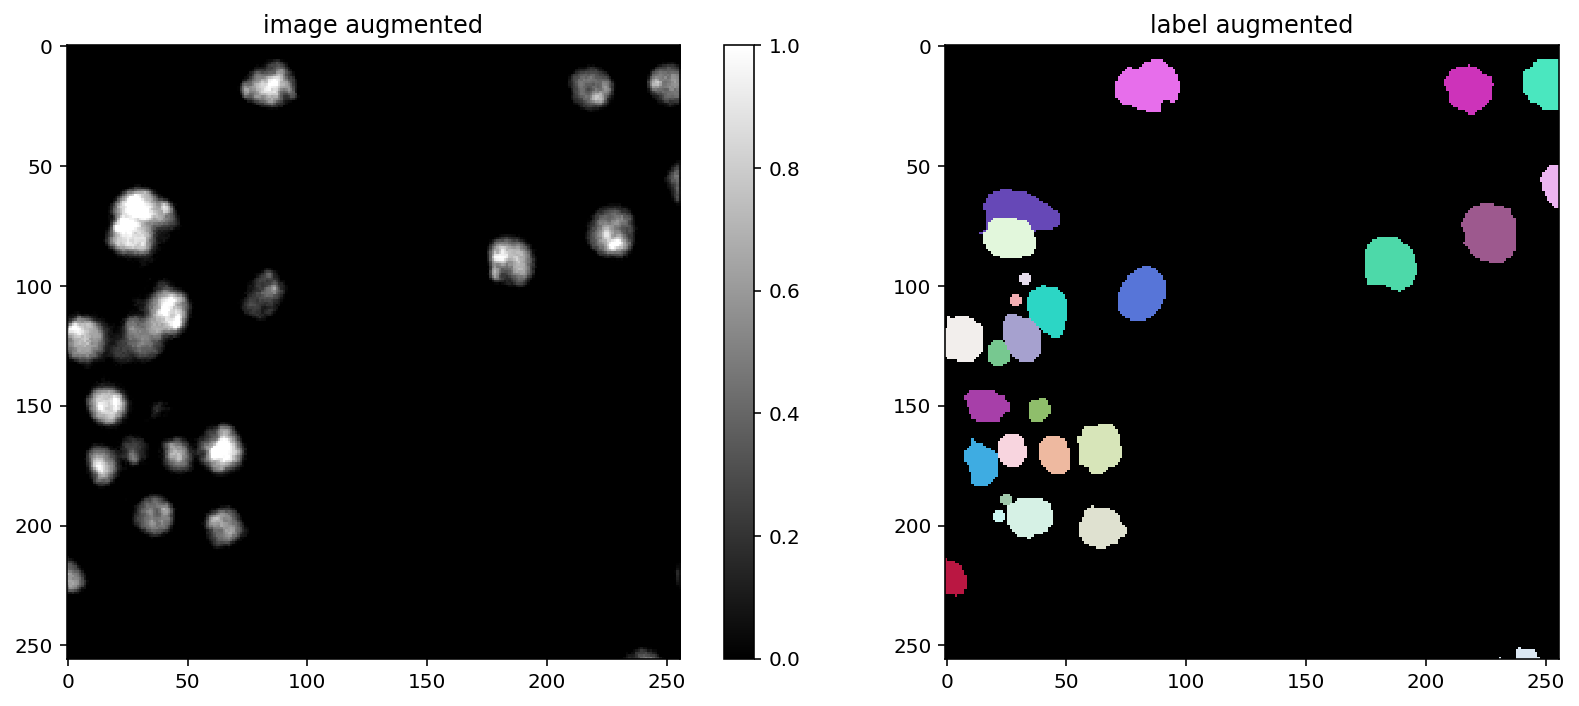

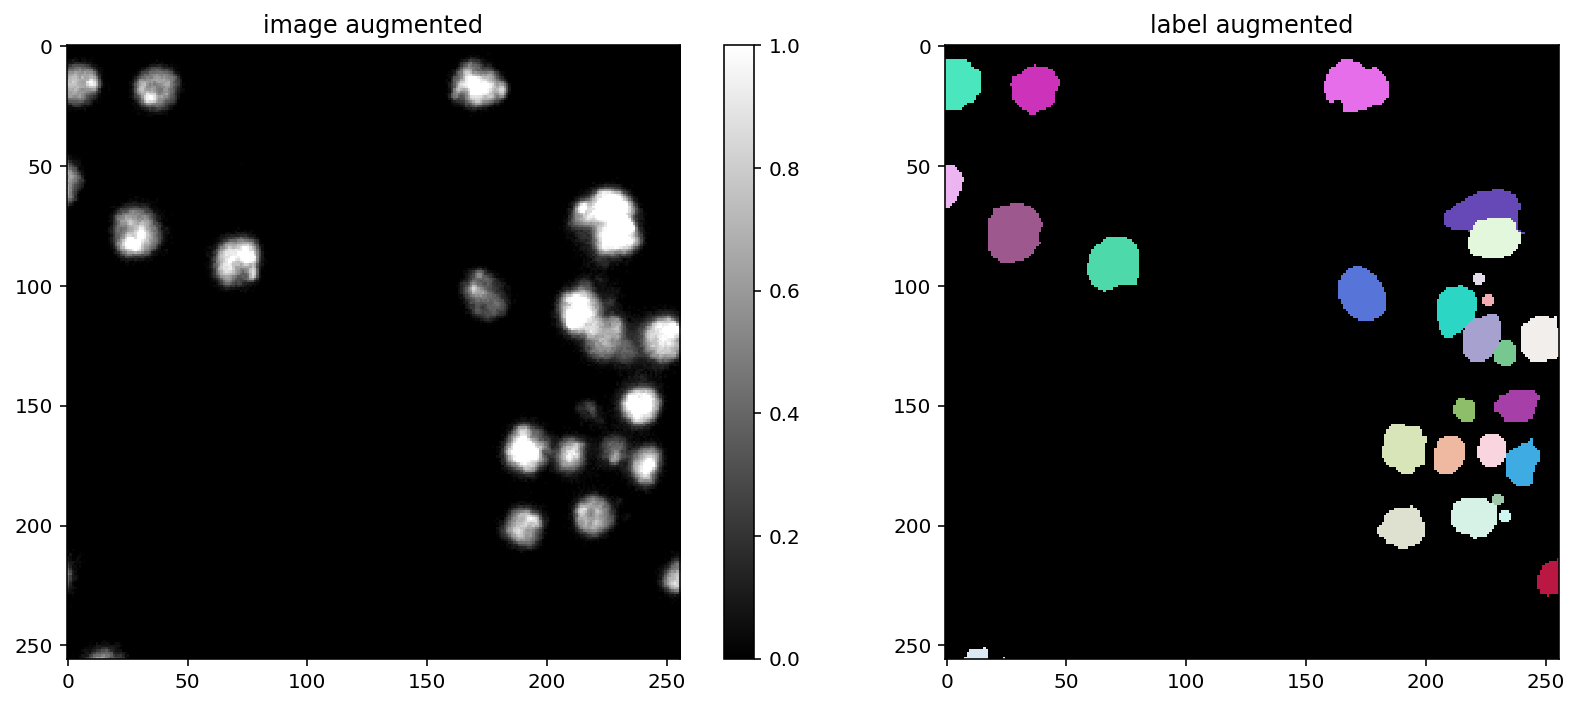

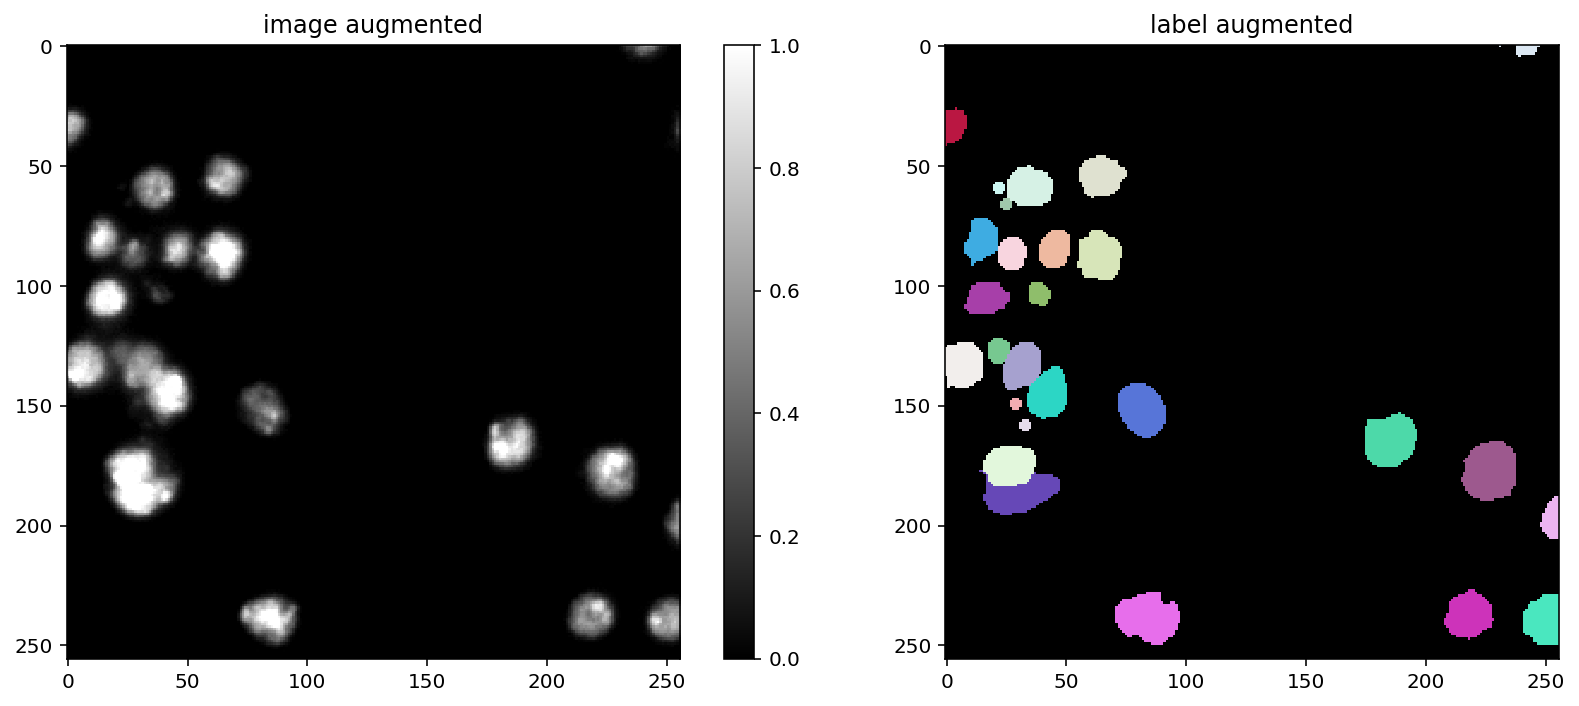

In [15]:
# plot some augmented examples
img, lbl = X[0],Y[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

# Training

In [ ]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)

Epoch 1/400
100/100 [==============================] - 249s 2s/step - loss: 2.1056 - prob_loss: 0.3097 - dist_loss: 8.9794 - prob_kld: 0.2347 - dist_relevant_mae: 8.9674 - dist_relevant_mse: 165.5766 - val_loss: 1.8995 - val_prob_loss: 0.2116 - val_dist_loss: 8.4395 - val_prob_kld: 0.1440 - val_dist_relevant_mae: 8.4275 - val_dist_relevant_mse: 147.1405 - lr: 3.0000e-04
Epoch 2/400
100/100 [==============================] - 95s 948ms/step - loss: 1.8221 - prob_loss: 0.2247 - dist_loss: 7.9873 - prob_kld: 0.1505 - dist_relevant_mae: 7.9753 - dist_relevant_mse: 131.5476 - val_loss: 1.6993 - val_prob_loss: 0.1599 - val_dist_loss: 7.6970 - val_prob_kld: 0.0923 - val_dist_relevant_mae: 7.6849 - val_dist_relevant_mse: 120.6569 - lr: 3.0000e-04
Epoch 3/400
100/100 [==============================] - 95s 951ms/step - loss: 1.5378 - prob_loss: 0.1377 - dist_loss: 7.0007 - prob_kld: 0.0651 - dist_relevant_mae: 6.9886 - dist_relevant_mse: 103.7779 - val_loss: 1.5159 - val_prob_loss: 0.0989 - val_d

# Visualization

First predict the labels for all validation images:

In [ ]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

Plot a GT/prediction example 

In [ ]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")